# Mental health in the Tech industry

I will begin the analysis by importing the modules to be used in this notebook:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import sqlite3 as sql
from scipy.stats import norm
import plotly.io as pio
pio.renderers.default = "svg"

pd.set_option('future.no_silent_downcasting', True)

Now I will import the database, create the cursor object and check the tables comprising this database.

In [2]:
conn = sql.connect("mental_health.sqlite")
cur = conn.cursor()

In [3]:
table_names = cur.execute(
    "SELECT name FROM sqlite_master WHERE type = 'table'"
).fetchall()
cur.close()
table_names = [name[0] for name in table_names]
table_names

['Answer', 'Question', 'Survey']

We can see that the database contains 3 tables, namely Answer, Survey, and Question. Let's see a preview of the contents of each of these tables:

In [4]:
survey_df = pd.read_sql("SELECT * FROM Survey", conn)
survey_df.head()

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [5]:
question_df = pd.read_sql("SELECT * FROM Question", conn, index_col="questionid")
question_df.head(9)

,questiontext
questionid,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state ..."
5,Are you self-employed?
6,Do you have a family history of mental illness?
7,Have you ever sought treatment for a mental he...
8,How many employees does your company or organi...
9,Is your employer primarily a tech company/orga...


In [6]:
answer_df = pd.read_sql("SELECT * FROM Answer", conn)
answer_df.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


Having had a look at the tables, I will now proceed to check them thoroughly and perform my analysis.

### What is the sample size?

Here I would like to find the number of all of the employees who responded to the survey.

The total number of survey respondents altogether for all of the years is: 4218


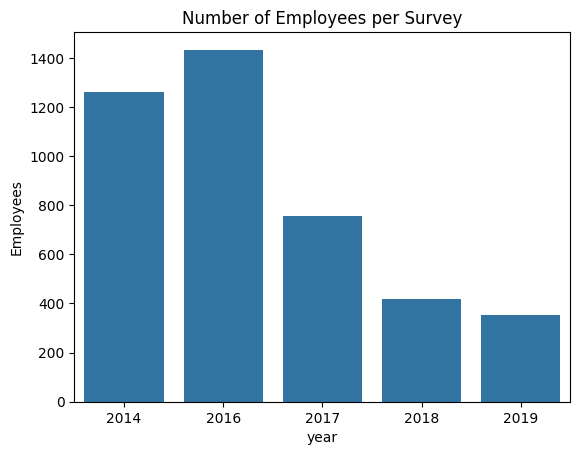

In [7]:
query = """
SELECT SurveyID year, COUNT(DISTINCT UserID) Employees
FROM Answer
GROUP BY SurveyID
"""
employee_per_survey = pd.read_sql(query, conn)

sns.barplot(x="year", y="Employees", data=employee_per_survey)
plt.title("Number of Employees per Survey")

print(
    f"The total number of survey respondents altogether for all of the years is: {employee_per_survey.Employees.sum()}"
)

The total number of survey responses altogether for all of the years is: 4988


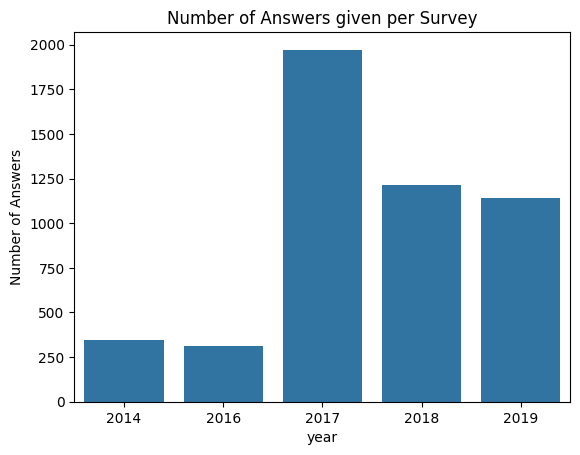

In [8]:
query = """
SELECT SurveyID year, COUNT(DISTINCT Answertext) Answer_no
FROM Answer
GROUP BY SurveyID
"""
employee_per_survey = pd.read_sql(query, conn)

sns.barplot(x="year", y="Answer_no", data=employee_per_survey)
plt.title("Number of Answers given per Survey")
plt.ylabel("Number of Answers")
print(
    f"The total number of survey responses altogether for all of the years is: {employee_per_survey.Answer_no.sum()}"
)

### What are the socio-demographic characteristics of the survey respondents?

There are 3 characteristics that I will be analysing, namely gender, age, and country. I will intially query and plot the sample data individually and then compare them with data collected from the population at large to see if there are any similarities.

Let's check the gender distribution of our sample and compare it with the distribution of the general population according to the data found in this [article](https://www.ined.fr/en/everything_about_population/demographic-facts-sheets/faq/more-men-or-women-in-the-world/#:~:text=The%20number%20of%20men%20and,496%20are%20women%20(49.6%25).)

Text(0.5, 1.0, 'Overall gender distribution of the survey respondents')

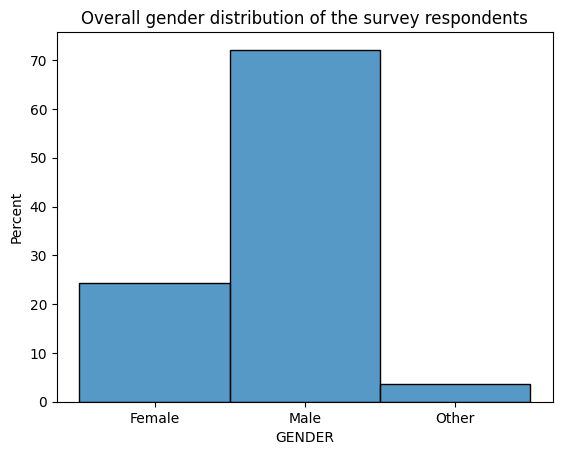

In [9]:
query = """
WITH tab AS (
SELECT CASE 
WHEN UPPER(AnswerText) == 'MALE' THEN 'Male'
WHEN UPPER(AnswerText) == 'FEMALE' THEN 'Female' ELSE 'Other' 
END AS GENDER
FROM Answer
WHERE questionid == 2
)

SELECT GENDER, COUNT(GENDER) COUNT
FROM tab
GROUP BY GENDER
"""

gender_df = pd.read_sql(query, conn)

sns.histplot(data=gender_df, x="GENDER", weights="COUNT", stat="percent")
plt.title("Overall gender distribution of the survey respondents")

Text(0.5, 1.0, 'Gender distribution of the survey respondents by year')

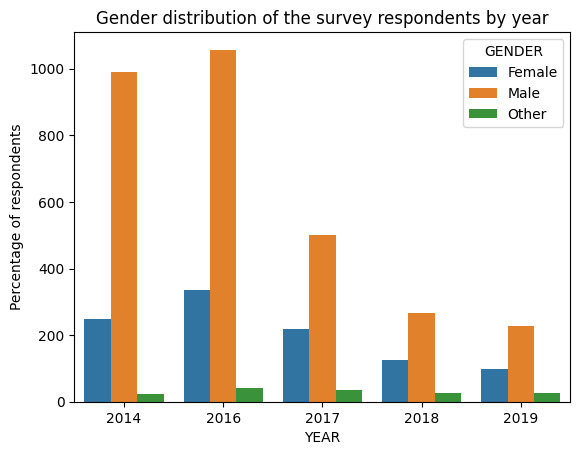

In [10]:
query = """
WITH tab AS (
SELECT SurveyID, CASE 
WHEN UPPER(AnswerText) == 'MALE' THEN 'Male'
WHEN UPPER(AnswerText) == 'FEMALE' THEN 'Female' ELSE 'Other' 
END AS GENDER
FROM Answer
WHERE questionid == 2
)

SELECT SurveyID YEAR, GENDER, COUNT(GENDER) COUNT
FROM tab
GROUP BY 1,2
"""

gender_by_year = pd.read_sql(query, conn)

sns.barplot(data=gender_by_year, x="YEAR", y="COUNT", hue="GENDER")
plt.ylabel("Percentage of respondents")
plt.title("Gender distribution of the survey respondents by year")

Now let's compare the distribution to the general population in the world:

Text(0.5, 1.0, 'Comparison of gender distribution of the survey respondents and the overal population')

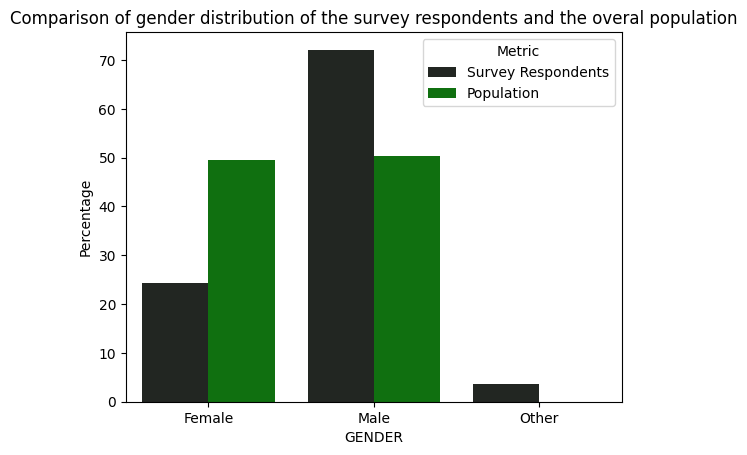

In [11]:
population_gender = pd.DataFrame.from_dict(
    {"Female": 49.6, "Male": 50.4, "Other": 0}, orient="index", columns=["Population"]
).reset_index()
gender = gender_df.join(population_gender.Population)
gender.COUNT = round(gender.COUNT / gender.COUNT.sum() * 100, 1)

plot_gender = {
    "GENDER": ["Female", "Male", "Other"] * 2,
    "Metric": ["Survey Respondents"] * 3 + ["Population"] * 3,
    "Percentage": gender.COUNT.to_list() + gender.Population.to_list(),
}

plot_gender = pd.DataFrame(plot_gender)

sns.barplot(plot_gender, x="GENDER", y="Percentage", hue="Metric", palette="dark:green")
plt.title(
    "Comparison of gender distribution of the survey respondents and the overal population"
)

From the figure above we can see that the gender distribution from the survey does not actually sit on the same level of that of the general population, which indicates the presence of some sort of sampling bias. To further confirm this finding, analysis of other demographic data (namely contry of origin and age) is required.

Let's now consider the **age** data in our database:

Text(0.5, 1.0, 'Age distribution of the survey respondents')

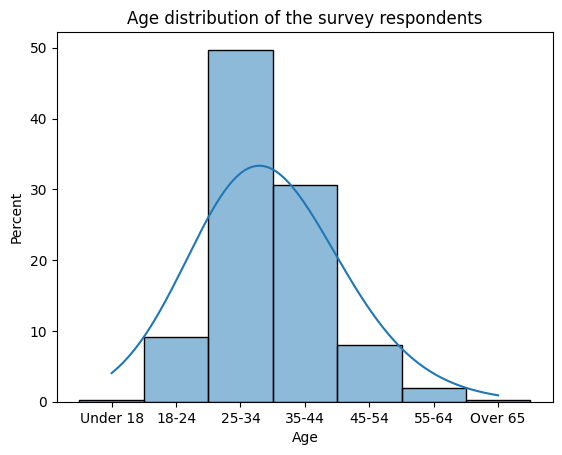

In [12]:
query = """
SELECT CASE
	WHEN AnswerText BETWEEN 15 AND 18 THEN 'Under 18'
	WHEN AnswerText BETWEEN 18 AND 24 THEN '18-24'
    WHEN AnswerText BETWEEN 25 AND 34 THEN '25-34'
    WHEN AnswerText BETWEEN 35 AND 44 THEN '35-44'
    WHEN AnswerText BETWEEN 45 AND 54 THEN '45-54'
    WHEN AnswerText BETWEEN 55 AND 64 THEN '55-64' 
    WHEN AnswerText BETWEEN 65 AND 85 THEN 'Over 65'
END AS Age,
COUNT(*) AS count
FROM Answer
WHERE questionid == 1
GROUP BY 1
ORDER BY 1
"""

age_df = pd.read_sql(query, conn)
age_df.Age = pd.Categorical(
    age_df.Age, ["Under 18", "18-24", "25-34", "35-44", "45-54", "55-64", "Over 65"]
)
age_df.sort_values("Age", inplace=True)

sns.histplot(data=age_df, x="Age", weights="count", stat="percent", kde=True)
plt.title("Age distribution of the survey respondents")

Text(0.5, 1.0, 'Employment rate distribution')

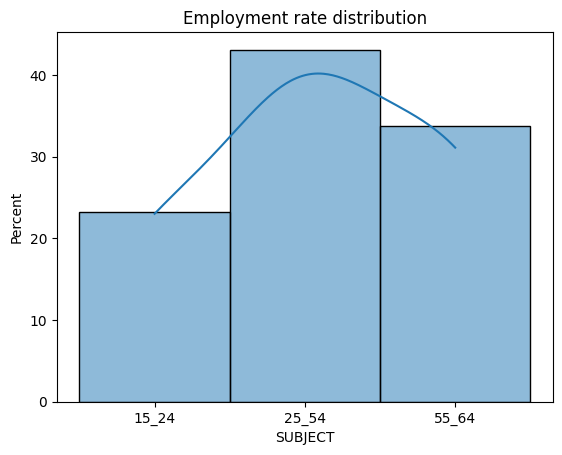

In [13]:
employment_rate = pd.read_csv("OECD_employment_rate.csv")
employment_rate.sort_values(["SUBJECT", "TIME_PERIOD"], inplace=True)
employment_rate = employment_rate.reindex(
    columns=["SUBJECT", "TIME_PERIOD", "OBS_VALUE"]
)

employment_rate

sns.histplot(
    data=employment_rate, x="SUBJECT", weights="OBS_VALUE", stat="percent", kde=True
)
plt.title("Employment rate distribution")

I used data from [OECD data explorer](https://data-explorer.oecd.org/vis?lc=en&df[ds]=DisseminateArchiveDMZ&df[id]=DF_DP_LIVE&df[ag]=OECD&df[vs]=&av=true&pd=2017%2C2019&dq=OECD%2BOAVG.EMPAGE...A&to[TIME_PERIOD]=false&vw=tb) to plot the distribution of the employment rate worldwide based on age groups. I then compare it with the plot above it which was derived from our sample's data to see if there are any similarities. In my opinion the two plotted distributions of the age groups are similar to each other, which indicates that there is little no bias towards age selection in the sample.  

Let's now consider location data in our sample:

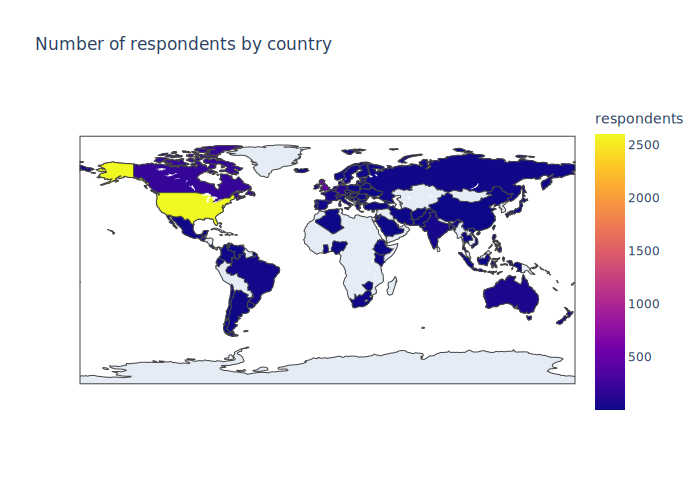

In [14]:
query = """
SELECT AnswerText country, COUNT(AnswerText) respondents
FROM Answer
WHERE questionid == 3
GROUP BY AnswerText
ORDER BY 2 DESC
"""

country_df = pd.read_sql(query, conn)

country_df.loc[0, "country"] = "United States"
country_df = country_df.groupby("country").respondents.sum().reset_index()

px.choropleth(
    country_df,
    locations="country",
    locationmode="country names",
    color="respondents",
    title="Number of respondents by country",
)

### Is there any evidence of sampling bias?

After consulting the sociodemographic analysis, I would conclude that:
1. There is evidence of gender bias.
2. There is very little evidence of age bias.
3. There is evidence of geogrpahic distribution bias, as it is highly skewed towards the US.

The way that the sample data was collected causes the current biases. While I have no information on how the survey was conducted, I can only assume that it was an opt-in survey which has resulted in our sample being a non-probability sample.

# Exploring questions:

Below I will dive deeper into specific questions and the answers that have been collected for each of these questions respectively. This will serve to create a better understanding on the comparative analysis that is to follow where I will analyze the relationship between the collected answers to derive broader conclusions on the population.

The questions that I will be raising are the following:

- Is family history an indicator of likelyhood of an employee's mental health disease ? If yes, what could be the probability of such likelyhood given some family history exists?

- If at all, would employees rather disclose an issue with their coworker or their employer? What does this tell us about the stigma about mental health in the workplace?

- To what extent does having workplace wellness programs correlate with reduced mental health stigma?

- Does company size correlate with the likelihood of employees seeking mental health treatment? 

- Is there a significant difference in mental health condition prevalence between tech industry employees and other industries?

### Q1: Is family history an indicator of likelyhood of an employee's mental health disease ? If yes, what could be the probability of such likelyhood given some family history exists?

To answer this question, I would first need to analyze the answers from questions 33 and 6.

In [15]:
def plot_question(q: list[int]) -> None:
    """
    This function plots the distribution of answers for a given question.
    Parameters:
    - q: list, contains the question IDs
    """
    for q_num in q:
        query = f" SELECT AnswerText FROM Answer WHERE questionid == {q_num}"
        a = pd.read_sql(query, conn)
        sns.countplot(data=a, y="AnswerText")
        plt.title(str(q_num) + "." + question_df.loc[q_num].questiontext)
        plt.show()

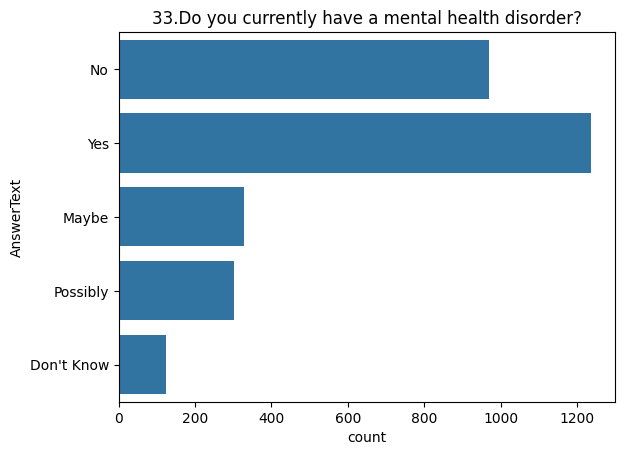

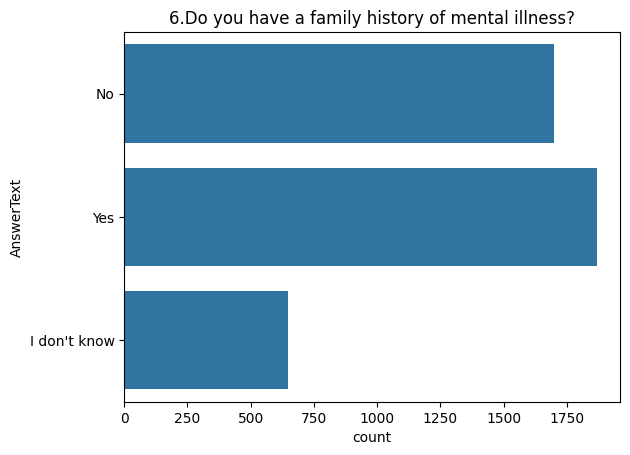

In [16]:
plot_question([33, 6])

In [17]:
query = """
SELECT 
    AnswerText,
    SUM(CASE WHEN QuestionID = 6 THEN 1 ELSE 0 END) AS "History",
    SUM(CASE WHEN QuestionID = 33 THEN 1 ELSE 0 END) AS "Disorder"
FROM 
    Answer
WHERE 
    QuestionID IN (6, 33)
GROUP BY  1
"""

question1 = pd.read_sql(query, conn)

question1.drop(0, inplace=True)
question1.loc[1, "AnswerText"] = "I don't know"
question1.loc[4, "AnswerText"] = "Maybe"
question1 = question1.groupby("AnswerText").sum()

question1

,History,Disorder
AnswerText,,
I don't know,649,0
Maybe,0,628
No,1701,969
Yes,1868,1237


Text(0.5, 1.0, 'Correlation matrix of history of, and mental health disorder')

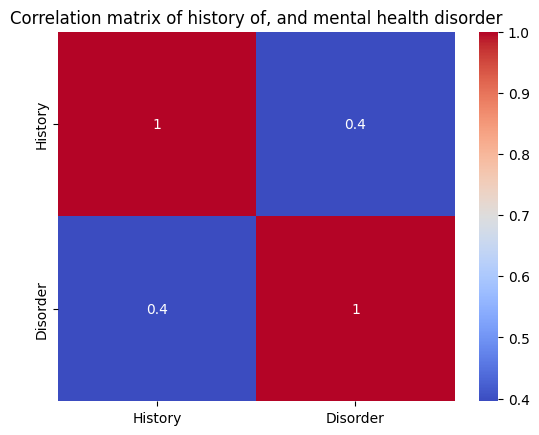

In [18]:
query = """
SELECT UserID,
    MAX(CASE WHEN QuestionID = 6 THEN AnswerText END) AS History,
    MAX(CASE WHEN QuestionID = 33 THEN AnswerText END) AS Disorder
FROM Answer
WHERE QuestionID IN (6, 33)
GROUP BY UserID
HAVING Disorder IS NOT NULL
"""

answers1 = pd.read_sql(query, conn, index_col="UserID")
replace = {
    "Yes": 1,
    "No": 0,
    "I don't know": 0.5,
    "Don't Know": 0.5,
    "Maybe": 0.5,
    "Possibly": 0.5,
}
answers1.replace(replace, inplace=True)
corr_matrix = answers1.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation matrix of history of, and mental health disorder")

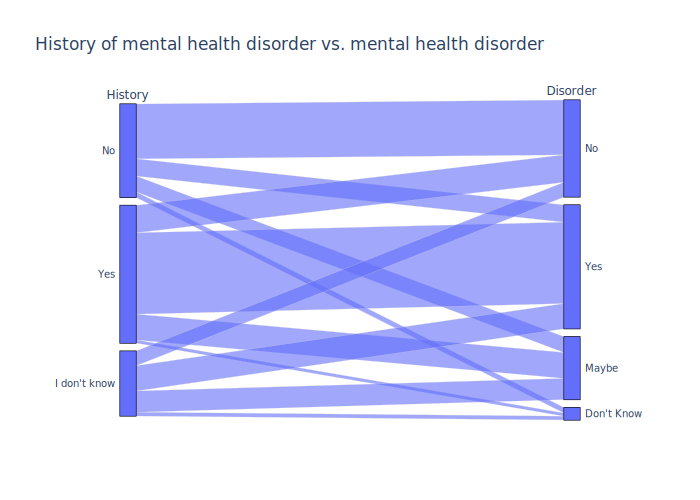

In [19]:
query = """
SELECT UserID,
    MAX(CASE WHEN questionid = 6 THEN answertext END) AS History,
    MAX(CASE WHEN questionid = 33 THEN answertext END) AS Disorder
FROM 
    Answer
WHERE 
    questionid IN (6, 33)
GROUP BY 1
HAVING Disorder IS NOT NULL
"""

plot_question1 = pd.read_sql(query, conn, index_col="UserID")
plot_question1.replace({"Possibly": "Maybe"}, inplace=True)
px.parallel_categories(
    plot_question1, title="History of mental health disorder vs. mental health disorder"
)

From the results above, I can say that there is a moderate positive correlation (Pearson correlation value 0.4) between having a family history of a mental health disorder and actually having been diagnosed with one. Therefore, it is difficult to conclude that there could be any sort of causational relationship either where family history indicates the presence of a mental health disorder.
Nonetheless, I will proceed to calculate the probability of such an event:

In [20]:
P_history = question1.History["Yes"] / question1.History.sum()
P_disorder = question1.Disorder["Yes"] / question1.Disorder.sum()

print(
    f"The probability of a person haing a mental health disorder given that he/she has a family history of it is {P_history * P_disorder * 100: 0.2f}%"
)

The probability of a person haing a mental health disorder given that he/she has a family history of it is  19.33%


### Q2: If at all, would employees rather disclose an issue with their coworker or their employer? What does this tell us about the stigma about mental health in the workplace?

First I will be considering the answers given to questions 58, 60, and 56. First, I will create a Parallel categories diagram using the answers to give a better visual representation to it.
Lastly, I will plot the Pearson correlation heatmap using the answers to see if there was any correlation between negative behaviour sourrounding mental health issues and discussing such issues with coworkers and/or employers.

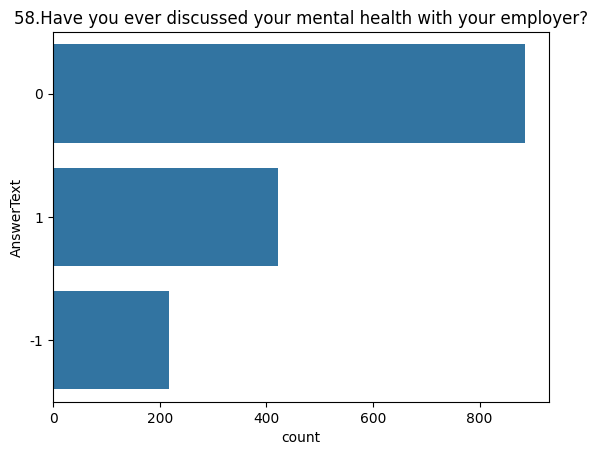

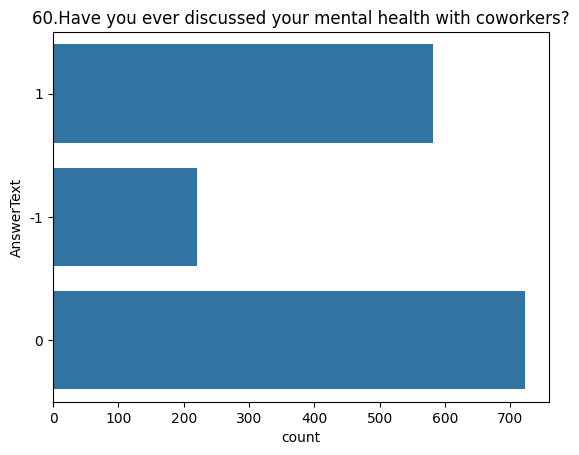

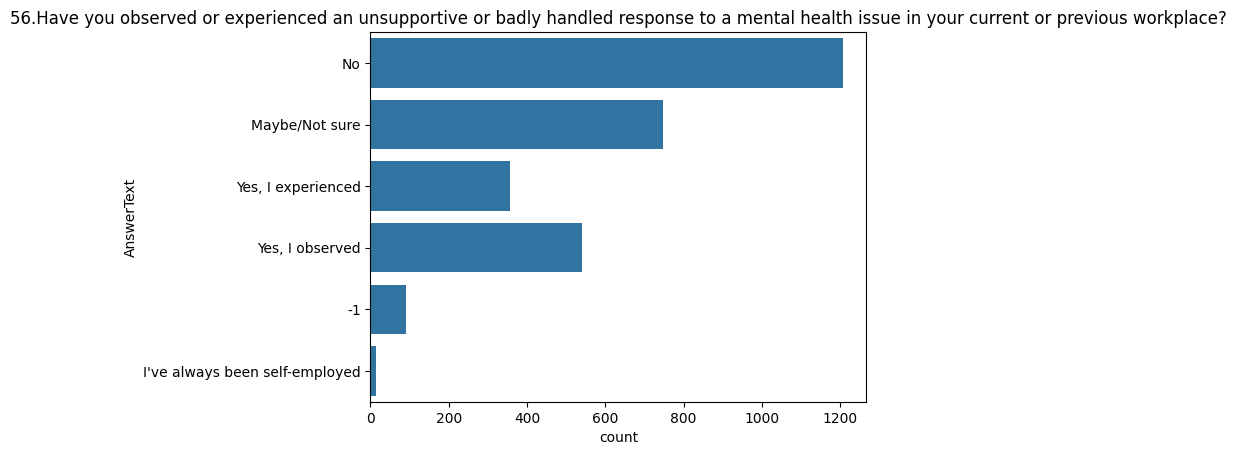

In [21]:
plot_question([58, 60, 56])

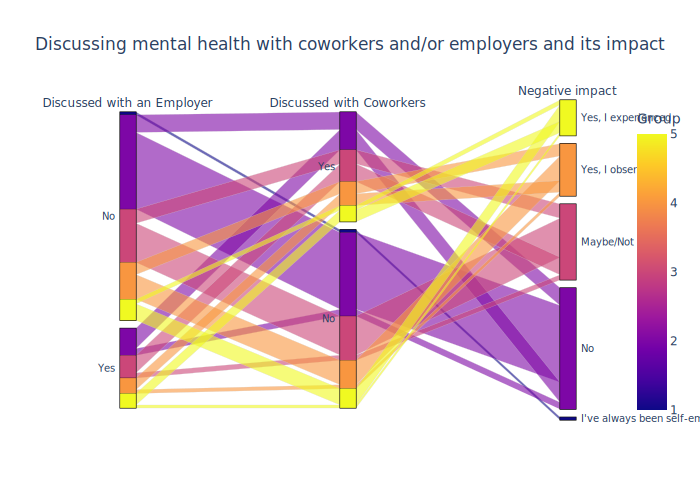

In [22]:
query = """
SELECT UserID,
    MAX(CASE WHEN questionid = 60 THEN answertext END) AS Coworkers,
    MAX(CASE WHEN questionid = 58 THEN answertext END) AS Employer,
    MAX(CASE WHEN questionid = 56 THEN answertext END) AS Negative_impact
FROM 
    Answer
WHERE 
    questionid IN (60, 58, 56)
GROUP BY 1
HAVING Coworkers IS NOT NULL AND Employer IS NOT NULL AND Negative_impact IS NOT NULL
"""
plot_question2 = pd.read_sql(query, conn, index_col="UserID")
plot_question2.replace({"1": "Yes", "0": "No", "-1": "No"}, inplace=True)

replace = {
    "Yes, I experienced": 5,
    "Yes, I observed": 4,
    "Maybe/Not sure": 3,
    "No": 2,
    "I've always been self-employed": 1,
}
plot_question2["Group"] = plot_question2.Negative_impact.replace(replace)

px.parallel_categories(
    plot_question2,
    dimensions=["Employer", "Coworkers", "Negative_impact"],
    labels={
        "Employer": "Discussed with an Employer",
        "Coworkers": "Discussed with Coworkers",
        "Negative_impact": "Negative impact",
    },
    title="Discussing mental health with coworkers and/or employers and its impact",
    color="Group",
)

Text(0.5, 1.0, 'Correlation matrix of discussing mental health with coworkers and/or employers and its impact')

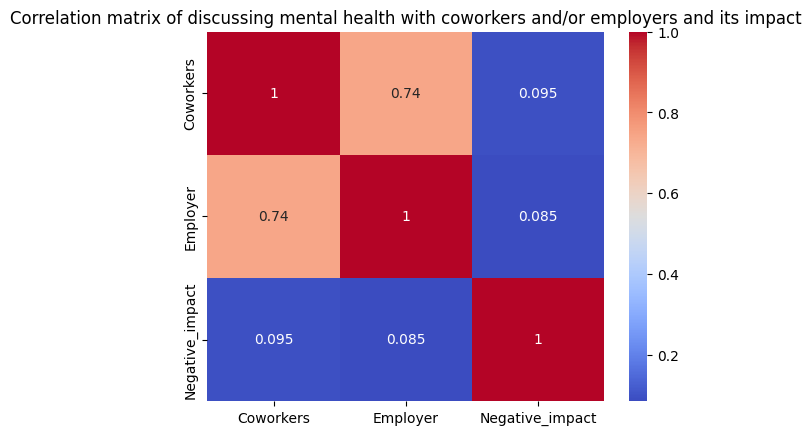

In [23]:
answers2 = pd.read_sql(query, conn, index_col="UserID")
replace = {
    "Yes, I experienced": 1,
    "Yes, I observed": 1,
    "Maybe/Not sure": 0.5,
    "No": 0,
    "I've always been self-employed": 0,
}
answers2.replace(replace, inplace=True)
corr_matrix2 = answers2.corr()

sns.heatmap(corr_matrix2, annot=True, cmap="coolwarm")
plt.title(
    "Correlation matrix of discussing mental health with coworkers and/or employers and its impact"
)

The results of both the correlation heatmap and the diagram show that:
1. there is a strong tendency for people who discuss mental health issues with their coworkers to also discuss them with employers (and vice versa).
2. there is no (or very little) tendency to observe/experience any negative impact because of a dicussion about mental health issues with coworkers/emplyers.

### Q3: To what extent does having workplace wellness programs correlate with reduced mental health stigma?

More often than not there is a stigma around metal health in the workplace that makes it difficult to take mental health seriously (or at least as seriously as physical health). Through this question I would like to investigate if there is any sort of relationship between the presence of workplace wellness programs that focus/discuss mental health and mental health being taken seriously.

To perform my analysis I will beign by considering the answers to questions 95 and 91. I will then plot the parallel categories diagram and then proceed to investigating potential correlations

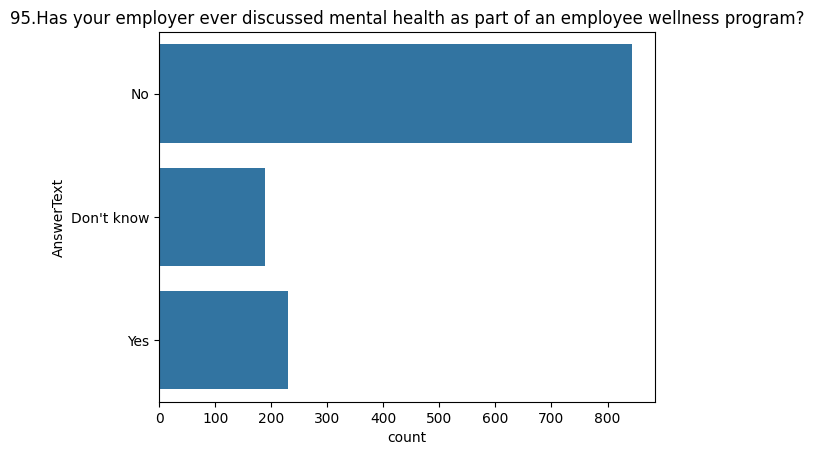

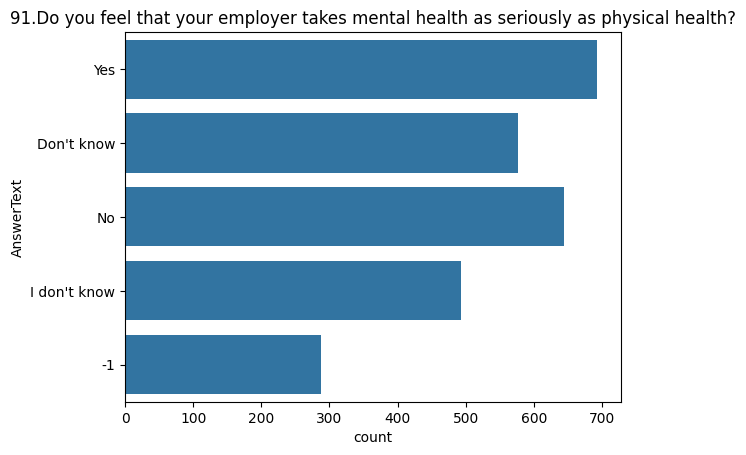

In [24]:
plot_question([95, 91])

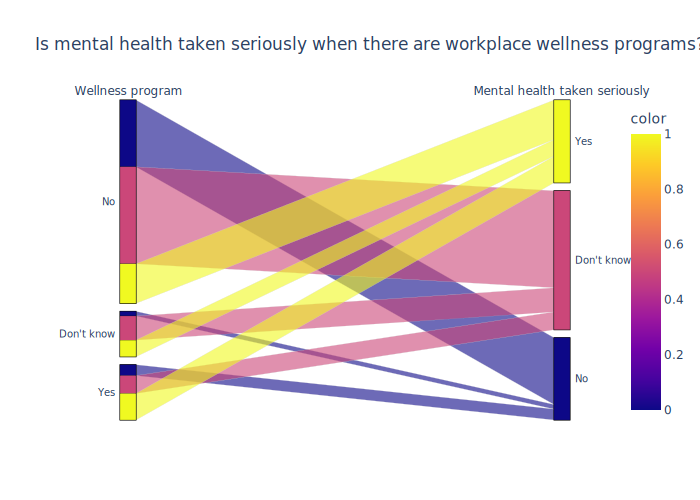

In [25]:
query = """
SELECT UserID,
    MAX(CASE WHEN QuestionID = 95 THEN AnswerText END) AS Wellness_program,
    MAX(CASE WHEN QuestionID = 91 THEN AnswerText END) AS Taken_seriously
FROM Answer
WHERE QuestionID IN (95, 91)
GROUP BY UserID
HAVING Wellness_program IS NOT NULL
"""

plot_question3 = pd.read_sql(query, conn, index_col="UserID")
plot_question3.replace({"I don't know": "Don't know", "-1": "No"}, inplace=True)

px.parallel_categories(
    plot_question3,
    dimensions=["Wellness_program", "Taken_seriously"],
    labels={
        "Wellness_program": "Wellness program",
        "Taken_seriously": "Mental health taken seriously",
    },
    title="Is mental health taken seriously when there are workplace wellness programs?",
    color=plot_question3.Taken_seriously.replace(
        {"Yes": 1, "No": 0, "Don't know": 0.5}
    ),
)

Text(0.5, 1.0, 'Correlation matrix of wellness programs and mental health taken seriously')

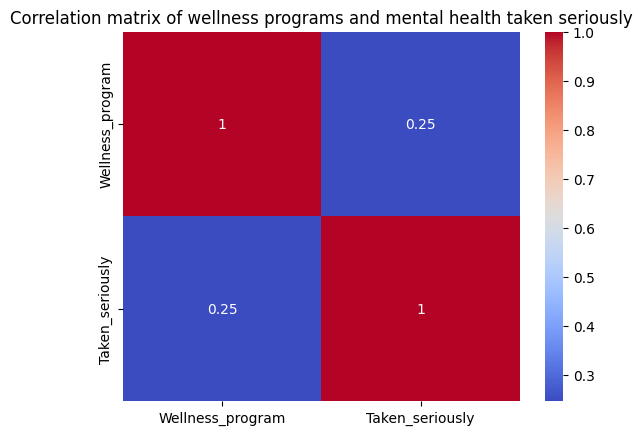

In [26]:
answers3 = pd.read_sql(query, conn, index_col="UserID")
replace = {"Yes": 1, "No": 0, "Don't know": 0.5, "I don't know": 0.5, "-1": 0}
answers3.replace(replace, inplace=True)
corr_matrix3 = answers3.corr()

sns.heatmap(corr_matrix3, annot=True, cmap="coolwarm")
plt.title("Correlation matrix of wellness programs and mental health taken seriously")

I can see from the diagram that even with the presence of wellness programs related to mental health, there are still cases where mental health is not taken seriously enough. Surprisingly, the majority of the workplaces where mental health is taken seriously did not offer any mental health wellness program.

Overall, there are a lot of people that are not sure if mental health is taken seriously enough, which makes it difficult to come up with a conclusion. Though, turning our attention to the correlation matrix, we can see that there is a pearson correlation score of 0.25 between the Wellness programs and mental health being taken seriously, which indicates a weak positive correlation.

Given everything, I can infer that the presence of wellness programs in the workplace contributes to the reduction of the stigma around mental health at a low extent.

### Q4: Does company size correlate with the likelihood of employees seeking mental health treatment?

For this question I will be analyzing the answers coming from questions 7 and 8 of the survey. 

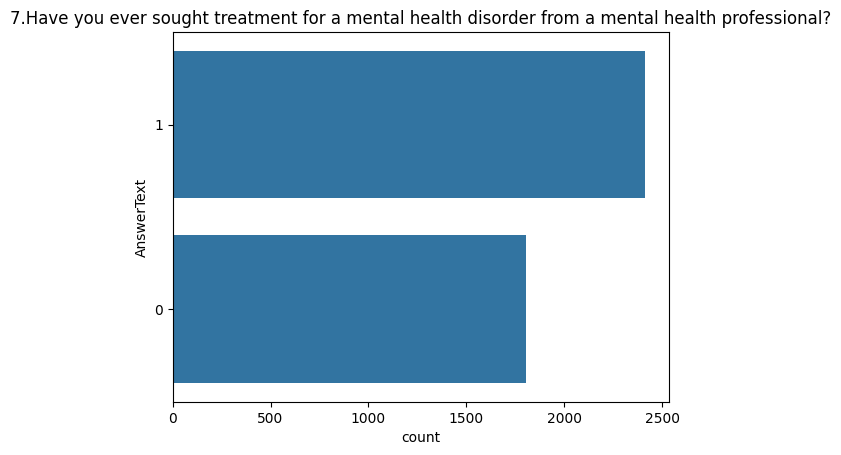

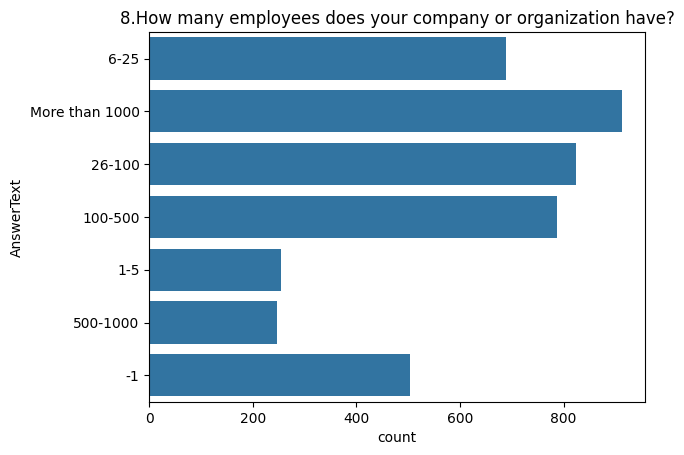

In [27]:
plot_question([7, 8])

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, '1-5'),
  Text(1, 0, '6-25'),
  Text(2, 0, '26-100'),
  Text(3, 0, '100-500'),
  Text(4, 0, '500-1000'),
  Text(5, 0, 'More than 1000')])

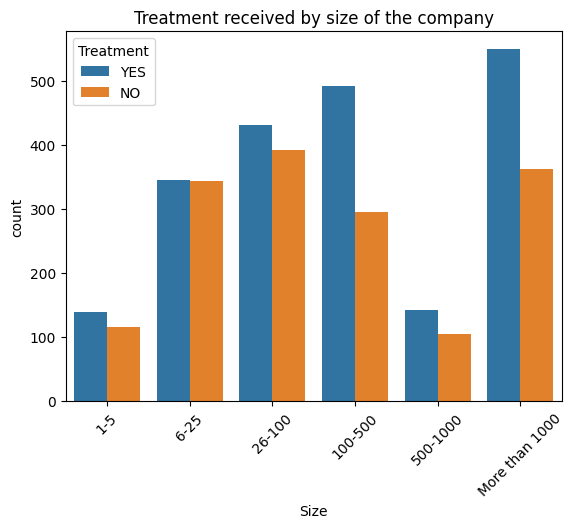

In [28]:
query = """
SELECT UserID,
    MAX(CASE WHEN QuestionID = 7 THEN AnswerText END) AS Treatment,
    MAX(CASE WHEN QuestionID = 8 THEN AnswerText END) AS Size
FROM Answer
WHERE QuestionID IN (7, 8)
GROUP BY UserID
"""
plot_question4 = pd.read_sql(query, conn, index_col="UserID")
plot_question4.drop(plot_question4[plot_question4.Size == "-1"].index, inplace=True)
plot_question4.Size = plot_question4.Size.astype("category")
category_order = [
    "1-5",
    "6-25",
    "26-100",
    "100-500",
    "500-1000",
    "More than 1000",
]

sns.countplot(data=plot_question4, x="Size", hue="Treatment", order=category_order)
plt.title("Treatment received by size of the company")
plt.legend(title="Treatment", labels=["YES", "NO"])
plt.xticks(rotation=45)

/tmp/ipykernel_48215/1453550508.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Text(0.5, 1.0, 'Correlation matrix of treatment received by size of the company')

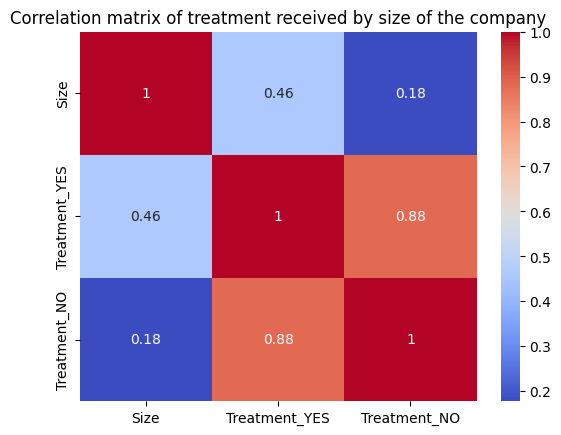

In [29]:
# split the data into yes and no counts
query = """
WItH tab AS (
SELECT UserID,
    MAX(CASE WHEN QuestionID = 7 THEN AnswerText END) AS Treatment,
    MAX(CASE WHEN QuestionID = 8 THEN AnswerText END) AS Size
FROM Answer
WHERE QuestionID IN (7, 8)
GROUP BY UserID
)

SELECT Size, SUM(Treatment) Treatment_YES, COUNT(Treatment) - SUM(Treatment) Treatment_NO
FROM tab
GROUP BY 1
"""

answers4 = pd.read_sql(query, conn).drop(0)

answers4.Size.replace(
    {
        "1-5": 1,
        "6-25": 2,
        "26-100": 3,
        "100-500": 4,
        "500-1000": 5,
        "More than 1000": 6,
    },
    inplace=True,
)

corr_matrix4 = answers4.corr()

sns.heatmap(corr_matrix4, annot=True, cmap="coolwarm")
plt.title("Correlation matrix of treatment received by size of the company")

From the countplot above, it is visible that with the increasing of company size, there is a tendency for the employees to seek professional mental health treatment. 

This tendency is further backed up by the correlation matrix, which indicates a moderate positive correlation between the number of employees who have sought treatment and the company size.

There is no apparent correlation between individuals who didn't seek treatment and company size.

### Q5: Is there a significant difference in mental health condition prevalence between tech industry employees and other industries?

For this question I will be calculating and comparing the overall prevalence rate of mental health disorders in the tech industry collected from the answers of questions 115 and 9, to the prevalence rate of those not in the tech industry.

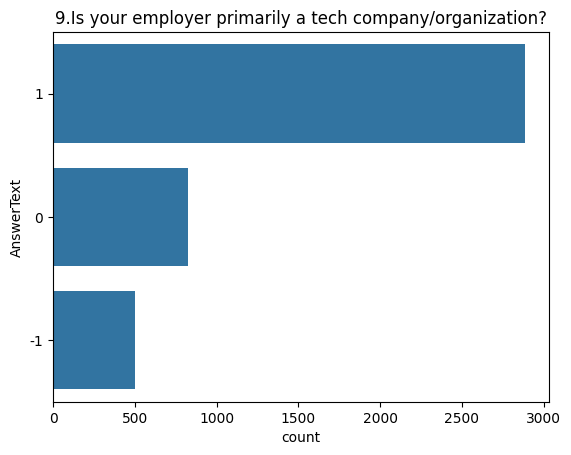

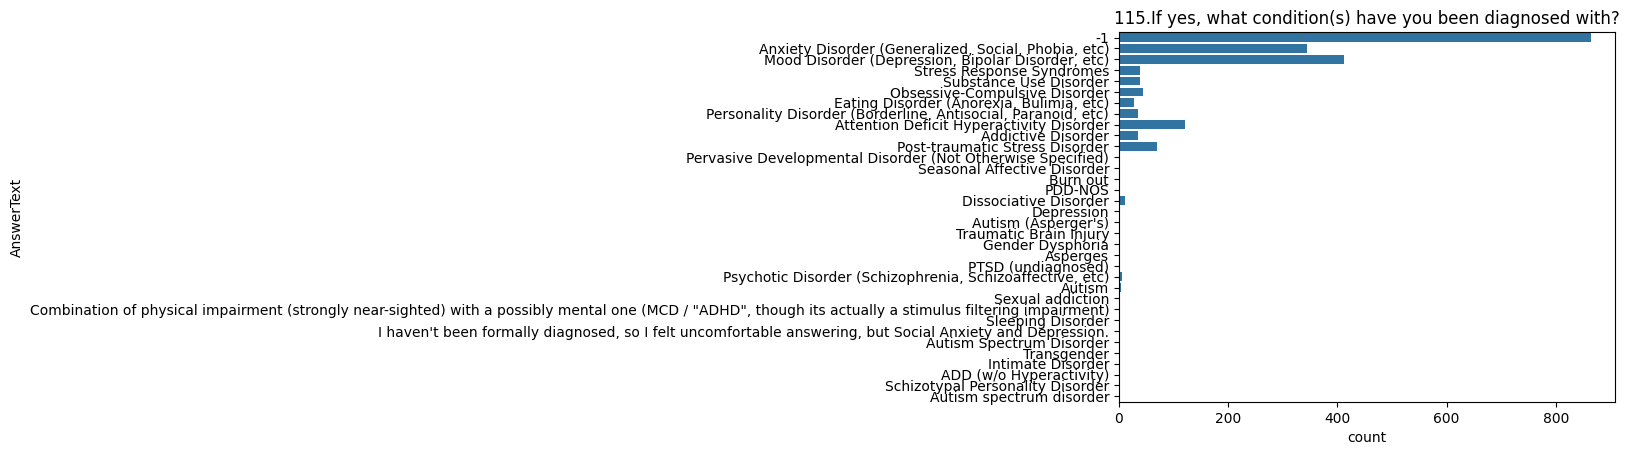

In [30]:
plot_question([9, 115])

Text(0.5, 0, 'Tech industry')

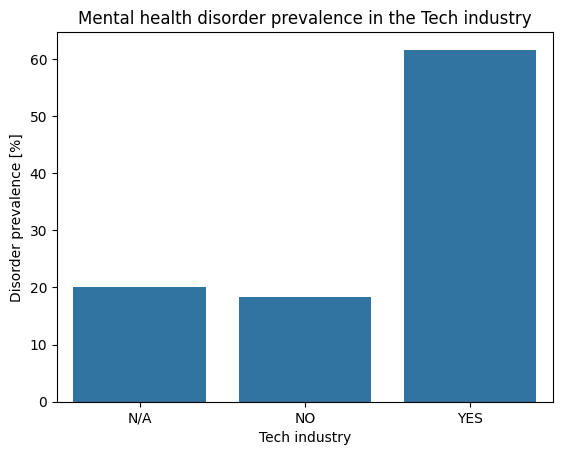

In [31]:
query = """
WItH tab AS (
SELECT UserID,
    MAX(CASE WHEN QuestionID = 9 THEN AnswerText END) AS Tech,
    MAX(CASE WHEN QuestionID = 115 THEN AnswerText END) AS Disorder
FROM Answer
WHERE QuestionID IN (9, 115)
GROUP BY UserID
HAVING Disorder is NOT NULL
)

SELECT Tech, COUNT(Disorder) Disorder_count
FROM tab
GROUP BY 1

"""

answers5 = pd.read_sql(query, conn)
answers5.Disorder_count = answers5.Disorder_count / answers5.Disorder_count.sum() * 100
answers5.Tech = answers5.Tech.replace({"-1": "N/A", "0": "NO", "1": "YES"})

sns.barplot(
    data=answers5,
    x="Tech",
    y="Disorder_count",
)
plt.title("Mental health disorder prevalence in the Tech industry")
plt.ylabel("Disorder prevalence [%]")
plt.xlabel("Tech industry")

From the plot above, we can see that the prevalence rate for mental health disorders in the Tech industry is about 61%, while for those who did not specify and those not in the Tech industry the prevalence rate hangs around 20%. Therefore, there is quite a significant difference between the industries.

# Prevalence rate of three diseases

Here I would like to calculate the prevalence rate of 3 different diseases listed in the answers of question 115 in the dataset. To do so I will go through the following steps:
1. I will select 3 diseases:
    - Anxiety Disorder (Generalized, Social, Phobia, etc) 
    - Attention Deficit Hyperactivity Disorder
    - Mood Disorder (Depression, Bipolar Disorder, etc)
2. I will find the prevalence rate.
3. I will find the Z-score for a 95% interval and the standard error (SE) using proportion groups (p).
4. I will calculate the confidence interval using the formula $CI = \mu \pm z \times \frac{SE}{\sqrt{n}}$
5. I will plot the data in a barchart including the confidence intervals.

In [32]:
query = """
WITH tab AS (
SELECT AnswerText Disease, CAST(COUNT(AnswerText) AS FLOAT) count
FROM Answer
WHERE questionid == 115
GROUP BY 1
)

SELECT Disease, count, count/ SUM(count) OVER() * 100 Prevalence
FROM tab
ORDER BY count DESC
"""
prevalence_df = pd.read_sql(query, conn)

z_score = norm.ppf(0.975)
n = prevalence_df["count"].sum()

p = prevalence_df["Prevalence"] / 100

SE = np.sqrt(p * (1 - p) / n)

prevalence_df["CI_lower"] = p * 100 - z_score * SE * 100
prevalence_df["CI_upper"] = p * 100 + z_score * SE * 100

prevalence_df[1:4]

,Disease,count,Prevalence,CI_lower,CI_upper
1,"Mood Disorder (Depression, Bipolar Disorder, etc)",412.0,19.884170,18.165604,21.602735
2,"Anxiety Disorder (Generalized, Social, Phobia,...",345.0,16.650579,15.046524,18.254634
3,Attention Deficit Hyperactivity Disorder,121.0,5.839768,4.830086,6.849451


Text(0, 0.5, 'Mental health disorder')

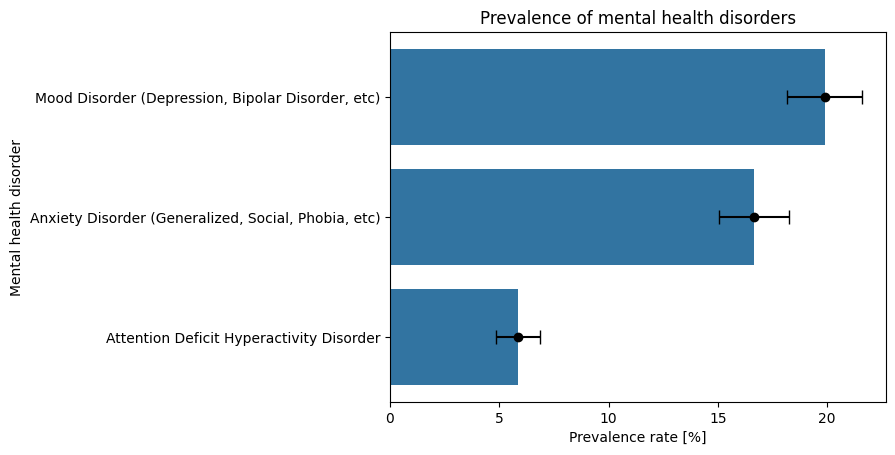

In [33]:
sns.barplot(
    data=prevalence_df[1:4],
    y="Disease",
    x="Prevalence",
)

plt.errorbar(
    x=prevalence_df[1:4].Prevalence,
    y=prevalence_df[1:4].Disease,
    xerr=[
        prevalence_df[1:4].Prevalence - prevalence_df[1:4].CI_lower,
        prevalence_df[1:4].CI_upper - prevalence_df[1:4].Prevalence,
    ],
    fmt="o",
    color="black",
    capsize=5,
)

plt.title("Prevalence of mental health disorders")
plt.xlabel("Prevalence rate [%]")
plt.ylabel("Mental health disorder")

The barchart above lists the top 3 mental health disorders with the highest prevalence rate and their confidence intervals.

# Summary

Based on the analysis of mental health in the tech industry, several key findings emerge:

1. **Sample Demographics**
    - Gender distribution shows significant sampling bias with males overrepresented (72.1%) compared to population statistics
    - Age distribution aligns well with general employment rates, showing little bias
    - Geographic distribution is heavily skewed toward the United States
    - There is evidence that the sample itself is a non-probability sample

2. **Mental Health Conditions**
    - Top 3 most prevalent conditions:
      - Mood Disorders (19.9%)
      - Anxiety Disorders (16.7%) 
      - ADHD (5.8%)
    - The tech industry shows a notably higher prevalence rate (61.6%) compared to other industries (18.4%)

3. **Workplace Dynamics**
    - Strong correlation (0.74) between discussing mental health with coworkers and employers
    - Limited negative impact reported from discussing mental health at work
    - Weak positive correlation (0.25) between wellness programs and mental health being taken seriously
    - Moderate positive correlation (0.46) between company size and likelihood of seeking treatment

4. **Family History Impact**
    - Moderate correlation (0.40) between family history and personal mental health conditions
    - Probability of having a mental health condition given family history is approximately 19.3%

This analysis suggests that while the tech industry faces significant mental health challenges, workplace attitudes are gradually becoming more supportive, particularly in larger companies. However, there remains room for improvement in mental health support programs and reducing stigma.


# Ideas for further analysis

1. **Scale and Response Rate Analysis**  
    My current sample size varies significantly across years (from 1433 responses in 2016 to 352 in 2019). I should investigate if this decline in responses affects the reliability of my conclusions and consider implementing weighted sampling techniques.

2. **Gender Bias Investigation**  
    With males representing 72.1% of respondents versus 50.4% in the general population, I need to analyze if this overrepresentation impacts the overall findings. Future analysis should include gender-normalized results to ensure balanced conclusions.

3. **Geographic Data Limitations**  
    My analysis is heavily skewed towards US-based respondents. I should either limit my conclusions to the US tech industry or seek additional data from other regions to make global inferences. This geographic bias potentially limits the generalizability of my findings.

4. **Timeframe Pattern Analysis**  
    My data spans from 2014 to 2019, but I haven't fully explored potential temporal patterns or trends. I should investigate whether attitudes towards mental health in tech have evolved over this period, particularly in relation to workplace wellness programs and stigma reduction.
